In [5]:
import pandas as pd 
from glob import glob
import os

def gscreenschots_df(samplefolder):
    img_paths = glob(samplefolder + '/*.jpg')
    img_paths.sort()
    img_df = pd.DataFrame(img_paths, columns=['img_path'])
    ftimestamp = lambda img_path: float(os.path.basename(img_path).replace('.jpg','').split("_")[-1])
    img_df["timestamp"] = img_df["img_path"].map(ftimestamp)
    return img_df.iloc[:,[1,0]]

def load_data(data_dir): 
    data = {}
    samplefolders = glob(data_dir + '/*')
    samplefolders.sort()
    for samplefolder in samplefolders:
        sample = {}
        sample['moves'] = pd.read_csv(samplefolder + '/mouse_moves.txt', names=['timestamp', 'px', 'py'])
        sample['clicks'] = pd.read_csv(samplefolder + '/mouse_clicks.txt', names=['timestamp', 'px', 'py', 'button'])
        sample['scrolls'] = pd.read_csv(samplefolder + '/mouse_scrolls.txt', names=['timestamp', 'px', 'py','dx', 'dy'])
        sample['keys'] = pd.read_csv(samplefolder + '/keys_pressed.txt', names=['timestamp', 'key'])
        sample['screenshots'] = gscreenschots_df(samplefolder)
        data[samplefolder.split('/')[-1]] = sample
    return data

data = load_data('../monitorpc/data')

13
12
10
14
11


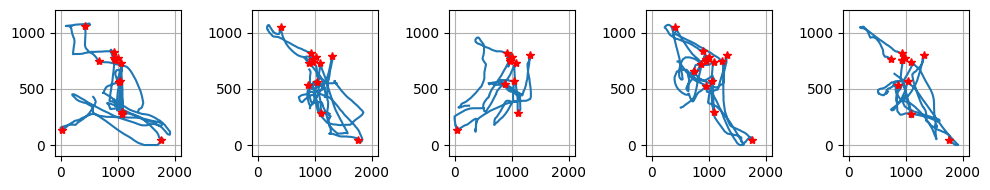

In [6]:
import matplotlib.pyplot as plt

# 1080x1920
plt.figure(figsize=(10,2))
for i,sample in enumerate(data.keys()):
    moves_df = pd.DataFrame(data[sample]['moves'], columns=['px','py'])
    clicks_df = pd.DataFrame(data[sample]['clicks'], columns=['px','py','button'])

    plt.subplot(1,5,i+1)
    plt.plot(moves_df['px'], moves_df['py'])
    plt.xlim([-100,2100])
    plt.ylim([-100,1200])
    plt.grid('on')

    lefts_df = clicks_df[clicks_df['button'] == 'Button.left']
    plt.plot(lefts_df['px'], lefts_df['py'], 'r*')
    print(len(lefts_df))

    rights_df = clicks_df[clicks_df['button'] == 'Button.right']
    plt.plot(rights_df['px'], rights_df['py'], 'g*')

plt.tight_layout()



In [7]:
for sample in data: 
    print('stats ({}):   min   mean   max'.format(sample))
    for typedata in data[sample]:
        x = data[sample][typedata]['timestamp'].values
        if len(x) > 0:
            dx = x[1:] - x[:-1]
            print('{}: '.format(typedata), round(dx.min(),4), round(dx.mean(),4), round(dx.max(),4))
    print()

stats (sample1):   min   mean   max
moves:  0.0 0.0206 4.9641
clicks:  0.7877 3.9108 11.3113
keys:  0.1624 11.6721 45.8135
screenshots:  0.0543 0.0694 0.1013

stats (sample2):   min   mean   max
moves:  0.0 0.0166 2.4485
clicks:  0.8261 3.6179 8.9801
keys:  0.1393 10.6785 41.9518
screenshots:  0.0534 0.0689 0.1101

stats (sample3):   min   mean   max
moves:  0.0 0.0165 1.7024
clicks:  0.9741 3.0811 6.0955
keys:  0.15 8.1187 31.7584
screenshots:  0.0559 0.0702 0.082

stats (sample4):   min   mean   max
moves:  0.0 0.0179 3.2557
clicks:  0.9071 2.8377 6.3096
scrolls:  0.0462 0.057 0.0677
keys:  0.1564 9.3458 36.3598
screenshots:  0.0526 0.0704 0.0831

stats (sample5):   min   mean   max
moves:  0.0 0.0183 2.836
clicks:  0.7699 3.2972 8.2997
keys:  0.1874 10.7754 31.5615
screenshots:  0.0526 0.0693 0.0872



In [9]:
### sincronizar los datos y verificanlo creando un video con el cursor mostrando sus acciones y las del teclado
from moviepy.editor import *
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# pip uninstall moviepy decorator
# pip install moviepy
# La percepcion (screenshots) comanda la sincronia 
font = ImageFont.truetype("Arial.ttf", 100)

img_list = []
for sample in ['sample4']: 
    for i in range(len(data[sample]['screenshots'])):
        img_path = data[sample]['screenshots']['img_path'][i]
        img = Image.open(img_path)
        img1 = ImageDraw.Draw(img)   

        # Cursor positions
        ti = data[sample]['screenshots']['timestamp'][i]
        abs_diff = abs(data[sample]['moves']['timestamp'] - ti)
        ## duda: debo pnr un umbral?
        closest_index = abs_diff.idxmin()
        mx, my = data[sample]['moves']['px'][closest_index], data[sample]['moves']['py'][closest_index]
        img1.polygon([(mx,my),(mx-10,my+20),(mx+10,my+20)], fill ="black", outline ="red")

        # Showing clicks
        abs_diff = abs(data[sample]['clicks']['timestamp'] - ti)
        if abs_diff.min() < 0.1: 
            closest_index = abs_diff.idxmin()
            cx, cy = data[sample]['clicks']['px'][closest_index], data[sample]['clicks']['py'][closest_index]  
            button = data[sample]['clicks']['button'][closest_index]
            if button == 'Button.left': 
                img1.polygon([(cx,cy),(cx-10,cy+20),(cx+10,cy+20)], fill ="red", outline ="red")
            elif button == 'Button.right': 
                img1.polygon([(cx,cy),(cx-10,cy+20),(cx+10,cy+20)], fill ="yellow", outline ="yellow")

        # Showing scrolls
        abs_diff = abs(data[sample]['scrolls']['timestamp'] - ti)
        if abs_diff.min() < 0.3: 
            closest_index = abs_diff.idxmin()
            dx, dy = data[sample]['scrolls']['dx'][closest_index], data[sample]['scrolls']['dy'][closest_index]  
            if dx == 1: 
                img1.text((960, 540), 'up', font = font, align='center', fill='blue')
            if dy == 1: 
                img1.text((960, 540), 'down', font = font, align='center', fill='blue')

        # Showing keyboard events
        abs_diff = abs(data[sample]['keys']['timestamp'] - ti)
        if abs_diff.min() < 0.3: 
            closest_index = abs_diff.idxmin()
            key = data[sample]['keys']['key'][closest_index].strip("'")
            img1.text((960, 540), key, font = font, align='center', fill='red')

        img_list.append(np.asarray(img))
    ts = (data[sample]['screenshots']['timestamp'][1:].values - data[sample]['screenshots']['timestamp'][:-1].values).mean()
    clip = ImageSequenceClip(img_list, fps=1/ts)
    clip.ipython_display(width = 500, maxduration = 1000) 

'''
mask = np.stack([hmap,np.zeros((1080,1920)),np.zeros((1080,1920))], axis=2)
new_list = []
for img in img_list:
    new_img = np.clip((50*mask + img), 0, 255)
    new_list.append(new_img)
'''

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


'\nmask = np.stack([hmap,np.zeros((1080,1920)),np.zeros((1080,1920))], axis=2)\nnew_list = []\nfor img in img_list:\n    new_img = np.clip((50*mask + img), 0, 255)\n    new_list.append(new_img)\n'

In [82]:
## Entrenar un modelo del mundo ?
## Entrenar un modelo prompt -> actions?
## Entrenar un modelo como el D. ha para letra japneses? 

¿cua es umbral correcto para la sincronia? 

How to train a RL model to a specific task in a real pc without damage? 

Contactar a lucas (segunda vez): mi propuesta 



'Key.enter'